In [4]:
import argparse
import pandas as pd
import numpy as np
import math
import re
import os
import sys

from scipy import stats
from functools import reduce

from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

from sklearn.model_selection import StratifiedKFold
from sksurv.linear_model import CoxPHSurvivalAnalysis

import time
import copy

import multiprocessing
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import pathlib
os.environ['PATH'] = os.environ['PATH'] + ';' + r"C:\ProgramData\Anaconda3\envs\OMSExpmt\Library\bin\graphviz"

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import datetime
import plotly.graph_objs as go
import plotly.io as pio
from graphviz import Digraph
from numpy import nan as NaN
import random
random.seed(10)
from sklearn.model_selection import train_test_split    
from sklearn.metrics import roc_auc_score
import pickle 

from joblib import Parallel, delayed
sys.path.append('../')
dir_env = './'

In [5]:
# axis_font = {'fontname':'Arial', 'size':'14'}
axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

## Функции риска

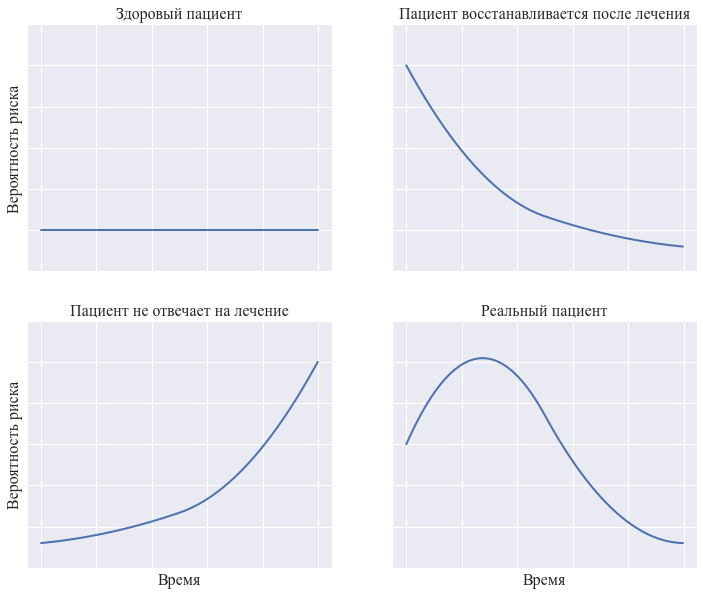

In [230]:
from scipy.interpolate import interp1d
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

titles = ['Здоровый пациент',
          'Пациент восстанавливается после лечения',
          'Пациент не отвечает на лечение',
          'Реальный пациент']

x = [1,2,3,4]
values = [[5, 5, 5, 5],
          [25, 10, 5, 3],
          [3, 5, 10, 25],
          [15, 25, 10, 3]]

for i in range(4):
    f2 = interp1d(x, values[i], kind='quadratic')
    x_num = np.linspace(min(x), max(x), 500)
    axs[i//2][i%2].set_ylim(0, 30)
#     axs[i//2][i%2].set_xlabel("Время", **axis_font)
#     axs[i//2][i%2].set_ylabel("h(t)", **axis_font)
    if i >= 2:
        axs[i//2][i%2].set_xlabel("Время", **axis_font)
    if i % 2 == 0:
        axs[i//2][i%2].set_ylabel("Вероятность риска", **axis_font)
    axs[i//2][i%2].set_title(titles[i], **axis_font)
#     axs[i//2][i%2].text(0.5, 0.9, titles[i], horizontalalignment='center',
#                         verticalalignment='center', transform=axs[i//2][i%2].transAxes)
    axs[i//2][i%2].plot(f2(x_num))
    axs[i//2][i%2].tick_params(left=False,
                               bottom=False,
                               labelleft=False,
                               labelbottom=False)
#     plt.xlabel('Время')
#     plt.ylabel('h(t)')
#     plt.title('h(t) для здорового человека')
plt.show()

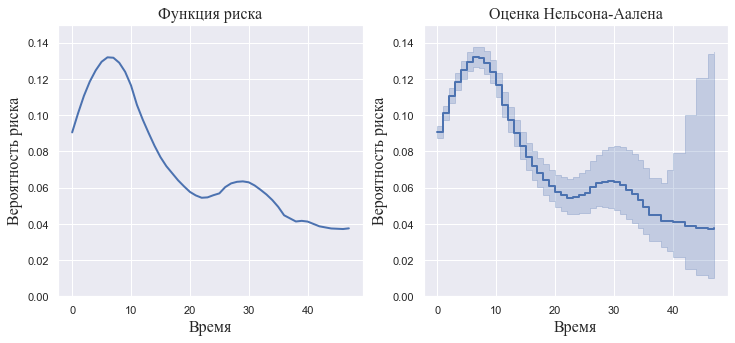

In [487]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import BreslowFlemingHarringtonFitter

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

data = load_dd()
data.head()
kmf = KaplanMeierFitter()
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)

naf = NelsonAalenFitter(alpha = 0.2)
naf.fit(T, event_observed=E)

# kmf.survival_function_.plot(ax = axs[0], legend = False)
naf.smoothed_hazard_(bandwidth = 10).plot(ax = axs[0], legend = False)#, show_censors = True, censor_styles={"marker": "o", "ms": 4})
# naf.plot_hazard(bandwidth = 10, ax = axs[1], legend = False, ci_show = False)#, censor_styles={"marker": "o", "ms": 4})
naf.plot_hazard(bandwidth = 10, ax = axs[1], legend = False, ci_show = True)#, censor_styles={"marker": "o", "ms": 4})

# axs[0].set_title('Survival function')
axs[0].set_ylim([0, 0.15])
axs[1].set_ylim([0, 0.15])

axs[0].set_title('Функция риска', **axis_font)
axs[1].set_title('Оценка Нельсона-Аалена', **axis_font)

axs[0].set_xlabel("Время", **axis_font)
axs[0].set_ylabel("Вероятность риска", **axis_font)

# axs[1].set_title('Hazard function')
axs[1].set_xlabel("Время", **axis_font)
axs[1].set_ylabel("Вероятность риска", **axis_font)
#axs[1].set_ylabel("Hazard probability", **axis_font)

# axs[2].set_xlabel("Время", **axis_font)
# axs[2].set_title('Оценка c доверительными интервалами', **axis_font)

plt.show()

## Функции выживаемости

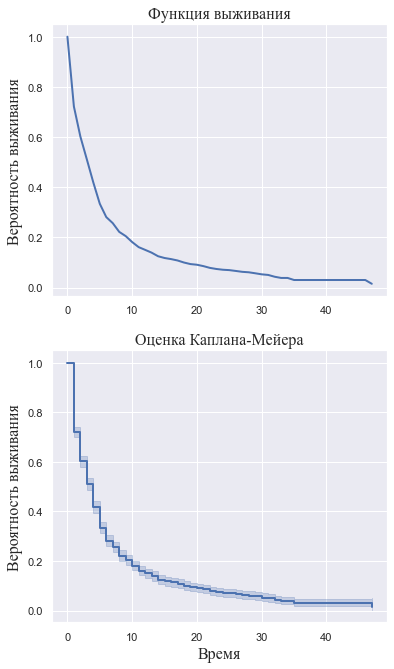

In [18]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

fig, axs = plt.subplots(2, 1, figsize=(6, 11))
data = load_dd()
data.head()
kmf = KaplanMeierFitter()
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot(ax = axs[0], legend = False)
# kmf.plot_survival_function(ax = axs[1], legend = False, ci_show = False)
kmf.plot_survival_function(ax = axs[1], legend = False)#, show_censors = True, censor_styles={"marker": "o", "ms": 4})#, show_censors = True, censor_styles={"marker": "o", "ms": 4})

axs[0].set_title('Функция выживания', **axis_font)
axs[1].set_title('Оценка Каплана-Мейера', **axis_font)

axs[0].set_xlabel(" ", **axis_font)
axs[0].set_ylabel("Вероятность выживания", **axis_font)

axs[1].set_xlabel("Время", **axis_font)
axs[1].set_ylabel("Вероятность выживания", **axis_font)

# axs[2].set_title('Оценка с доверительными интервалами', **axis_font)
# axs[2].set_xlabel("Время", **axis_font)
# axs[2].set_ylabel("Вероятность выживания", **axis_font)
plt.show()

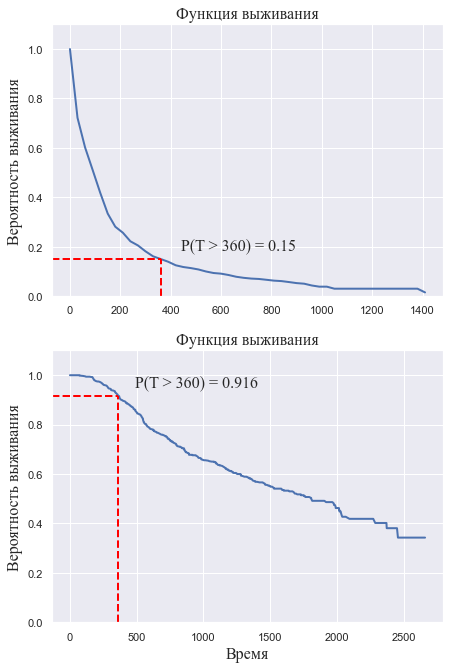

In [3]:
from lifelines.datasets import load_dd, load_gbsg2
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

fig, axs = plt.subplots(2, 1, figsize=(7, 11))
data = load_dd()
data_gbsg = load_gbsg2()
data.head()
kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

kmf.fit(data["duration"]*30, event_observed = data["observed"])
kmf2.fit(data_gbsg["time"], event_observed = data_gbsg["cens"])

kmf.survival_function_.plot(ax = axs[0], legend = False)
kmf2.survival_function_.plot(ax = axs[1], legend = False)

axs[0].set_title('Функция выживания', **axis_font)
axs[1].set_title('Функция выживания', **axis_font)

axs[0].set_ylim([0, 1.1])
axs[1].set_ylim([0, 1.1])

axs[0].set_xlabel("", **axis_font)
axs[0].set_ylabel("Вероятность выживания", **axis_font)

axs[1].set_xlabel("Время", **axis_font)
axs[1].set_ylabel("Вероятность выживания", **axis_font)

x = 360.0

axs0_size = axs[0]._viewLim._points[1] - axs[0]._viewLim._points[0]
axs1_size = axs[1]._viewLim._points[1] - axs[1]._viewLim._points[0]

axs0_xmin = axs[0]._viewLim._points[0][0]
axs1_xmin = axs[1]._viewLim._points[0][0]

y1 = kmf.survival_function_.loc[x][0]
y2 = kmf2.survival_function_.loc[x][0]

axs[0].axhline(y=y1, xmin=0.0, xmax=(x - axs0_xmin)/axs0_size[0], color = 'red', linestyle = '--')
axs[0].axvline(x=x, ymin=0.0, ymax=y1/axs0_size[1], color = 'red', linestyle = '--')

axs[1].axhline(y=y2, xmin=0.0, xmax=(x - axs1_xmin)/axs1_size[0], color = 'red', linestyle = '--')
axs[1].axvline(x=x, ymin=0.0, ymax=y2/axs1_size[1], color = 'red', linestyle = '--')

axs[0].text((x - axs0_xmin)/axs0_size[0]+0.2, 
            y1/axs0_size[1]+0.05, 
            "P(T > {}) = {:.3}".format(int(x), y1), 
            horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes,
            **axis_font)

axs[1].text((x - axs1_xmin)/axs1_size[0]+0.2, 
            y2/axs1_size[1]+0.05, 
            "P(T > {}) = {:.3}".format(int(x), y2), 
            horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes,
            **axis_font)
# axs[0].text(y1, x/kmf.durations.max(), "Вероятность прожить больше 120 дней равна", horizontalalignment='center',
#                     verticalalignment='center', transform=axs[0].transAxes)
# axs[1].text(0.5, 0.9, "Вероятность прожить больше 120 дней равна", horizontalalignment='center',
#                     verticalalignment='center', transform=axs[1].transAxes)
plt.show()

## Таблицы времен жизни

In [435]:
def get_table_mortality(dur, obs, num_inter = 10):
    table_mortality = pd.DataFrame(columns=["Начало", "Конец",
                                            "Число в начале", "Число изъятых", 
                                            "Число изучаемых", "Число умерших", 
                                            "Доля умерших", "Доля выживших"])
    intervals = range(min(dur), max(dur), max(int((max(dur) - min(dur))/num_inter), 1))

    for i_srt,i_end in zip(intervals[:-1], intervals[1:]):
        inter_st = (dur >= i_srt)
        inter_end = (dur < i_end)

        censored = (1 - obs[inter_st & inter_end]).sum()
        table_mortality = table_mortality.append({
                        "Начало":i_srt,
                        "Конец":i_end-1,
                        "Число в начале": inter_st.sum(), 
                        "Число изъятых" : censored,
                        "Число изучаемых": inter_st.sum() - censored//2,
                        "Число умерших": obs[inter_st & inter_end].sum(),
                        "Доля умерших": obs[inter_st & inter_end].sum()/(inter_st.sum() - censored/2),#(inter_st & inter_end).sum(),
                        "Доля выживших": 1 - obs[inter_st & inter_end].sum()/(inter_st.sum() - censored/2)#(inter_st & inter_end).sum(),
                        }, ignore_index=True) 
    
    cumulat = (1 - table_mortality["Доля умерших"]).cumprod()
    table_mortality["Кумулятивная доля выживших"] = np.stack([1] + cumulat[:-1].to_list())
    return table_mortality

In [456]:
get_table_mortality(T, E, num_inter = 10)

,Начало,Конец,Число в начале,Число изъятых,Число изучаемых,Число умерших,Доля умерших,Доля выживших,Кумулятивная доля выживших
0,1.0,4.0,1808.0,167.0,1725.0,1009.0,0.585097,0.414903,1.000000
1,5.0,8.0,632.0,72.0,596.0,283.0,0.474832,0.525168,0.414903
2,9.0,12.0,277.0,30.0,262.0,85.0,0.324427,0.675573,0.217894
3,13.0,16.0,162.0,21.0,152.0,38.0,0.250825,0.749175,0.147203
4,17.0,20.0,103.0,18.0,94.0,19.0,0.202128,0.797872,0.110281
5,21.0,24.0,66.0,6.0,63.0,14.0,0.222222,0.777778,0.087990
6,25.0,28.0,46.0,9.0,42.0,6.0,0.144578,0.855422,0.068437
7,29.0,32.0,31.0,5.0,29.0,8.0,0.280702,0.719298,0.058542
8,33.0,36.0,18.0,3.0,17.0,5.0,0.303030,0.696970,0.042109
9,37.0,40.0,10.0,5.0,8.0,0.0,0.000000,1.000000,0.029349


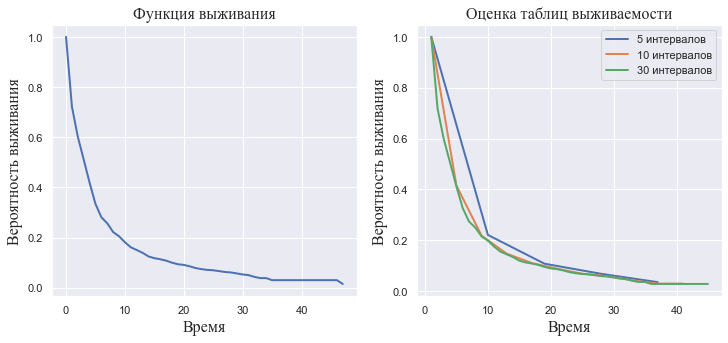

In [457]:
from lifelines.datasets import load_dd
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
data = load_dd()
data.head()
kmf = KaplanMeierFitter()
T = data["duration"]
E = data["observed"]

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot(ax = axs[0], legend = False)
get_table_mortality(T, E, num_inter = 5).set_index("Начало")["Кумулятивная доля выживших"].plot(ax = axs[1])#, show_censors = True, censor_styles={"marker": "o", "ms": 4})#, show_censors = True, censor_styles={"marker": "o", "ms": 4})
get_table_mortality(T, E, num_inter = 10).set_index("Начало")["Кумулятивная доля выживших"].plot(ax = axs[1])#, show_censors = True, censor_styles={"marker": "o", "ms": 4})#, show_censors = True, censor_styles={"marker": "o", "ms": 4})
get_table_mortality(T, E, num_inter = 30).set_index("Начало")["Кумулятивная доля выживших"].plot(ax = axs[1])#, show_censors = True, censor_styles={"marker": "o", "ms": 4})#, show_censors = True, censor_styles={"marker": "o", "ms": 4})

axs[0].set_title('Функция выживания', **axis_font)
axs[1].set_title('Оценка таблиц выживаемости', **axis_font)
axs[1].legend(["5 интервалов", "10 интервалов", "30 интервалов"])

axs[0].set_xlabel("Время", **axis_font)
axs[0].set_ylabel("Вероятность выживания", **axis_font)

axs[1].set_xlabel("Время", **axis_font)
axs[1].set_ylabel("Вероятность выживания", **axis_font)
plt.show()

In [101]:
# Расчет ожидаемого времени через S(t) = 0.5
kmf.survival_function_.index[np.where(kmf.survival_function_ > 0.5)[0][-1]]
# Расчет ожидаемого времени через мат.ожидание
np.trapz(kmf.survival_function_["KM_estimate"].to_numpy(), x=kmf.survival_function_.index)

90.0

In [498]:
data

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1803,Zambia,551,551.0,Eastern Africa,Africa,Levy Patrick Mwanawasa,Levy Patrick Mwanawasa.Zambia.2002.2007.Civili...,Non-democracy,Civilian Dict,2002,6,1
1804,Zambia,551,551.0,Eastern Africa,Africa,Rupiah Bwezani Banda,Rupiah Bwezani Banda.Zambia.2008.2008.Civilian...,Non-democracy,Civilian Dict,2008,1,0
1805,Zimbabwe,552,552.0,Eastern Africa,Africa,Ian Smith,Ian Smith.Zimbabwe.1965.1978.Civilian Dict,Non-democracy,Civilian Dict,1965,14,1
1806,Zimbabwe,552,552.0,Eastern Africa,Africa,Abel Muzorewa,Abel Muzorewa.Zimbabwe.1979.1979.Civilian Dict,Non-democracy,Civilian Dict,1979,1,1


<AxesSubplot:xlabel='Начало'>

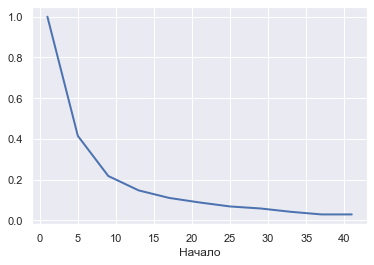

In [379]:
table_mortality.set_index("Начало")["Кумулятивная доля выживших"].plot()

## SPLIT

In [111]:
import survivors.datasets as ds
import survivors.criteria as scrit

X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
df = X.copy()
df["cDeath"] = y['cens']
df["dDeath"] = y['time']

# rule = "age <= 70"
# d1 = df.query(rule)
# d2 = df.loc[df.index.difference(d1.index),:]
# left_child_pair = (d1["cDeath"], d1["dDeath"])
# right_child_pair = (d2["cDeath"], d2["dDeath"])
# p_val = scrit.peto(right_child_pair[1], left_child_pair[1],
#                  right_child_pair[0], left_child_pair[0])

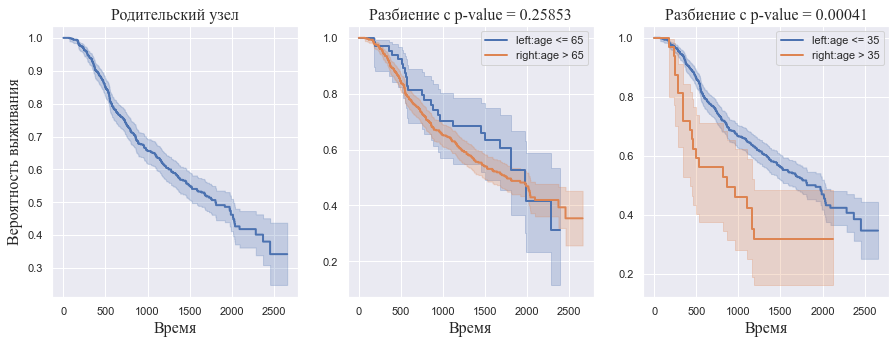

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

kmf0 = KaplanMeierFitter()
kmf0.fit(df["dDeath"], df["cDeath"], label = "Node of tree") 
kmf0.plot_survival_function(legend = False, ax = axs[0])
axs[0].set_title("Родительский узел", **axis_font)
axs[0].set_ylabel("Вероятность выживания", **axis_font)
axs[0].set_xlabel("Время", **axis_font)

categ = False
if categ:
    feature = "tumgrad"
    rules = [("[3]","[2, 1]"), ("[2]","[1, 3]")]
else:
    feature = "age"
    rules = ["65", "35"]
    
for i in range(len(rules)):
    if categ:
        rule1 = feature + " in " + rules[i][0]
        rule2 = feature + " in " + rules[i][1]
    else:
        rule1 = feature + " <= " + rules[i]
        rule2 = feature + " > " + rules[i]
        
    d1 = df.query(rule1)
    d2 = df.query(rule2)
    left_child_pair = (d1["cDeath"], d1["dDeath"])
    right_child_pair = (d2["cDeath"], d2["dDeath"])
    p_val = scrit.peto(right_child_pair[1].to_numpy(), left_child_pair[1].to_numpy(),
                       right_child_pair[0].to_numpy(), left_child_pair[0].to_numpy())

    kmf1 = KaplanMeierFitter()
    kmf1.fit(right_child_pair[1], right_child_pair[0], label = "left:" + rule1) 
    kmf2 = KaplanMeierFitter()
    kmf2.fit(left_child_pair[1], left_child_pair[0], label = "right:" + rule2)

    kmf1.plot_survival_function(ax = axs[i+1])
    kmf2.plot_survival_function(ax = axs[i+1])
    axs[i+1].set_xlabel("Время", **axis_font)
    axs[i+1].set_title('Разбиение с p-value = ' + str(round(p_val,5)), **axis_font)
# fig.suptitle('Split: rule = "' + rule + '", p-value =' + str(round(p_val,5)))

In [24]:
plt.show()

## WOE

In [589]:
feature = "regime"
arr = data[data[feature] == data[feature]]
arr['observed'] = 1 - arr['observed']
categs = pd.unique(arr[feature]).shape[0]
arr_notnan = arr.loc[:, [feature, 'observed', 'duration']].to_numpy().T

N_T = arr_notnan[1].shape[0]
N_D = arr_notnan[1].sum()
N_D_ = N_T - arr_notnan[1].sum()

df_woe_iv = pd.crosstab(arr_notnan[0],arr_notnan[1])
all_0 = df_woe_iv[0].sum()
all_1 = df_woe_iv[1].sum()

df_woe_iv["p_bd"] =  (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
df_woe_iv["p_bd_"] =  (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
df_woe_iv["p_b_d"] =  (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
df_woe_iv["p_b_d_"] =  (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

df_woe_iv["woe_pl"]= np.log(df_woe_iv["p_bd"] / df_woe_iv["p_bd_"])
df_woe_iv["woe_mn"]= np.log(df_woe_iv["p_b_d"] / df_woe_iv["p_b_d_"])

iv = ((df_woe_iv["p_bd"].to_numpy() - df_woe_iv["p_bd_"].to_numpy())*df_woe_iv["woe_pl"].to_numpy()).sum()

In [590]:
df_woe_iv.sort_values(by = 'woe_pl')

col_0,0,1,p_bd,p_bd_,p_b_d,p_b_d_,woe_pl,woe_mn
row_0,,,,,,,,
Mixed Dem,243,32,0.094118,0.165531,0.905882,0.834469,-0.564615,0.082114
Parliamentary Dem,504,81,0.238235,0.343324,0.761765,0.656676,-0.365416,0.148447
Presidential Dem,280,47,0.138235,0.190736,0.861765,0.809264,-0.321931,0.062857
Military Dict,180,56,0.164706,0.122616,0.835294,0.877384,0.295106,-0.049161
Civilian Dict,239,91,0.267647,0.162807,0.732353,0.837193,0.497107,-0.133793
Monarchy,22,33,0.097059,0.014986,0.902941,0.985014,1.868176,-0.086998


In [591]:
iv

0.31348766213196655

In [7]:
class WeightOfEvidence(object):
    def __init__(self, features):
        self.features = features

    def get_feature_woe(self, feature, X, y):
        a = pd.concat([X[feature], y], axis = 1)
        a = a[a[feature] == a[feature]]

        categs = pd.unique(a[feature]).shape[0]
        f_table = a.to_numpy().T

        N_T = y.shape[0]
        N_D = y.sum()
        N_D_ = N_T - y.sum()

        df_woe_iv = pd.crosstab(f_table[0],f_table[1])
        all_0 = df_woe_iv[0].sum()
        all_1 = df_woe_iv[1].sum()

        df_woe_iv["p_bd"] =  (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
        df_woe_iv["p_bd_"] =  (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
        df_woe_iv["p_b_d"] =  (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
        df_woe_iv["p_b_d_"] =  (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

        df_woe_iv["woe_pl"]= np.log(df_woe_iv["p_bd"] / df_woe_iv["p_bd_"])
        df_woe_iv["woe_mn"]= np.log(df_woe_iv["p_b_d"] / df_woe_iv["p_b_d_"])
        return (df_woe_iv["woe_pl"] - df_woe_iv["woe_mn"]).to_dict()

    def fit(self, X, y):
        feature_mapping = []
        for f in self.features:
            feature_mapping.append(self.get_feature_woe(f, X, y))
        self.features_woe = pd.Series(feature_mapping, index = self.features)
    
    def transform(self, X):
        for f in self.features:
            if f in X.columns:
                X[f] = X[f].map(self.features_woe[f])
        return X
    
    def get_inverse_keys(self, values, feature = None):
        return [k for k,v in self.features_woe[feature].items() if v in values]

In [85]:
def transform_woe(x_feat, y):
    a = np.vstack([x_feat,y]).T
    a = a[a[:,0] == a[:,0]]

    categs = np.unique(a[:,0]).shape[0]
    N_T = y.shape[0]
    N_D = y.sum()
    N_D_ = N_T - y.sum()

    df_woe_iv = pd.crosstab(a[:,0],a[:,1])
    all_0 = df_woe_iv[0].sum()
    all_1 = df_woe_iv[1].sum()

    df_woe_iv["p_bd"] =  (df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    df_woe_iv["p_bd_"] =  (df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)
    df_woe_iv["p_b_d"] =  (all_1 - df_woe_iv[1] + 1e-5) / (N_D + 1e-5)
    df_woe_iv["p_b_d_"] =  (all_0 - df_woe_iv[0] + 1e-5) / (N_D_ + 1e-5)

    df_woe_iv["woe_pl"]= np.log(df_woe_iv["p_bd"] / df_woe_iv["p_bd_"])
    df_woe_iv["woe_mn"]= np.log(df_woe_iv["p_b_d"] / df_woe_iv["p_b_d_"])
    features_woe = (df_woe_iv["woe_pl"] - df_woe_iv["woe_mn"]).to_dict()
    descr_np = np.vstack([df_woe_iv.index, (df_woe_iv["woe_pl"] - df_woe_iv["woe_mn"])])
    woe_x_feat = np.vectorize(features_woe.get)(x_feat)
    return (woe_x_feat, descr_np)

In [87]:
x_feat, descr_np = transform_woe(data['regime'].to_numpy(), 
                                 data['observed'].to_numpy())

In [96]:
arr_notnan[0], descr_np = transform_woe(arr_notnan[0], arr_notnan[1])

In [84]:
ind = descr_np[1] >= 0.0
l,r = list(descr_np[0, np.where(ind)[0]]), list(descr_np[0, np.where(~ind)[0]])
[' in %s' % (e) for e in [l,r]]

[" in ['Mixed Dem', 'Parliamentary Dem', 'Presidential Dem']",
 " in ['Civilian Dict', 'Military Dict', 'Monarchy']"]

## Схемы лечения

In [1]:
import survivors.datasets as ds
from survivors.tree import CRAID

X, y, features, categ, sch_nan = ds.load_covid_dataset()


c:\programdata\anaconda3\envs\omsexpmt\lib\site-packages\IPython\core\interactiveshell.py:3361: DtypeWarning: Columns (12,33,36,37,46,47,48,49,103,111,112,147,148,247,248,267,268,275,276,283,284,295,296,307,308) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Categ-contin var: has_odyshka_ili_zatrudnennoe_dyhanie
Categ-contin var: has_oschussh_zalozhen_v_grudnoi_kletke
Categ-contin var: has_slabost_ili_lomota
Categ-contin var: Пол
Categ-contin var: PCR_N
Categ-contin var: has_kashel
Categ-contin var: kashel_type
Categorical var: resultat_KT 6


In [2]:
X.isna().sum(axis = 0).sort_values()[-50:]

mos_light_1                                         0
MOS_LVF_MOK                                         0
MOS_PIP                                             0
MOS_MOK                                             0
N_MOS_CFP_LVF                                       0
MOS_CFP_LVF                                         0
MOS_CFP                                             0
mos_light_2                                         0
IGG_DEF                                         49726
IGM_DEF                                         49727
IGG_N                                           53629
IGM_N                                           53630
resultat_KT                                     98827
chdd                                            98827
temperatura_tela_value                          98827
АЛТ                                            118699
АСТ                                            118756
Определениекреатинина                          118972
days_s                      

In [2]:
X

,days_f,days_s,spo2,chdd,has_odyshka_ili_zatrudnennoe_dyhanie,temperatura_tela_value,has_oschussh_zalozhen_v_grudnoi_kletke,has_slabost_ili_lomota,Пол,возраст,...,mos_light_2,mos_middle_1,mos_middle_2,mos_middle_3,mos_middle_4,mos_hard_1,mos_hard_2,mos_hard_3,mos_cyto_1,mos_cyto_2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,NaN,18.0,1.0,38.1,1.0,1.0,0.0,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,91,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,51,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162913,NaN,NaN,NaN,18.0,0.0,37.6,0.0,1.0,1.0,73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,26,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,88,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162916,1.0,1.0,NaN,18.0,0.0,37.8,0.0,1.0,0.0,72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
CRAID_param_grid_lr = {
    "depth":10,
    "criterion":"peto",
    "min_samples_leaf":20,
    "thres_cont_bin_max":100,
    "signif": 0.05,
    "max_features":1.0
}
craid_tree = CRAID(**CRAID_param_grid_lr)
craid_tree.fit(X, y)

In [3]:
import numpy as np
t = X.copy()
for i in sch_nan:
    t[i] = np.nan
pred_scheme = craid_tree.predict(t, mode = "scheme", target = sch_nan[:23])

In [4]:
from survivors.visualise.visualise import pred_pers_km_count


In [5]:
pred_pers_km_count(pred_scheme.iloc[6], './MasterScheme/',
                       min_size = 10,
                       join = True)


Максимальное P-value: 0.935405105440221
Цепочки схем: Лекарственная_противоопухолевая_терапия_Первая_линия==0;Хирургическое_лечение_Первичной_опухоли_в_том_числе_с_удалением_регионарных_лимфатических_узлов==0;Лучевая_терапия_Первичной_опухоли_ложа_опухоли==0;Хирургическое_лечение==0;Химиолучевая_терапия==1; Лекарственная_противоопухолевая_терапия_Первая_линия==1;Хирургическое_лечение==0;Лекарственная_противоопухолевая_терапия_Вторая_линия==1;
Заменяются на: Лекарственная_противоопухолевая_терапия_Первая_линия==0;Хирургическое_лечение_Первичной_опухоли_в_том_числе_с_удалением_регионарных_лимфатических_узлов==0;Лучевая_терапия_Первичной_опухоли_ложа_опухоли==0;Хирургическое_лечение==0;Химиолучевая_терапия==1;|Лекарственная_противоопухолевая_терапия_Первая_линия==1;Хирургическое_лечение==0;Лекарственная_противоопухолевая_терапия_Вторая_линия==1;
Максимальное P-value: 0.7222282439072936
Цепочки схем: Лекарственная_противоопухолевая_терапия_Первая_линия==0;Хирургическое_лечение_Первичной_оп

In [39]:
from survivors.tests.experiment import run, import_tables, plot_results, get_best_by_full_name
# df = import_tables(['./EXP_RES/GBSG/NEW_GBSG_FULL_TABLE.xlsx'])
# df = import_tables(['./EXP_RES/NEW_Wuhan/WUHAN_SCIKIT.xlsx',
#                     './EXP_RES/NEW_Wuhan/WUHAN_TREE_TABLE.xlsx',
#                     './EXP_RES/NEW_Wuhan/WUHAN_BSTR_BOOST.xlsx',
#                     './EXP_RES/NEW_Wuhan/WUHAN_BOOST.xlsx',
#                     './EXP_RES/NEW_Wuhan/WUHAN_BOOST_ADD.xlsx'])
# df = import_tables(['./EXP_RES/NEW_PBC/PBC_FULL_SCIKIT.xlsx',
#                     './EXP_RES/NEW_PBC/PBC_TREE_TABLE.xlsx',
#                     './EXP_RES/NEW_PBC/PBC_BSTR_BOOST.xlsx',
#                     './EXP_RES/NEW_PBC/PBC_BOOST_ADD.xlsx'
#                     ])
df = import_tables(['./EXP_RES/ONK/ONK_SCIKIT.xlsx',
                    './EXP_RES/ONK/ONK_TREE_BSTR_BOOST.xlsx',
                    './EXP_RES/ONK/ONK_TREE_BSTR_BOOST_LEAF_30_50.xlsx',
                    './EXP_RES/ONK/ONK_BOOST_BAD.xlsx',
                    './EXP_RES/ONK/ONK_BOOST_BAD_ALL.xlsx',
                    './EXP_RES/ONK/ONK_BOOST_20_100_0.4.xlsx',
                    './EXP_RES/ONK/ONK_BOOST_20_100_0.2_0.5.xlsx',
                   ])

# df = import_tables(['./EXP_RES/COVID/COVID_SCIKIT_COX_ST_RF.xlsx',
#                     './EXP_RES/COVID/COVID_SCIKIT_GBOOST.xlsx',
#                     './EXP_RES/COVID/COVID_TREE.xlsx',
#                     './EXP_RES/COVID/COVID_BSTR_BOOST.xlsx',
#                     './EXP_RES/COVID/COVID_BOOST_LEAF_250.xlsx',
#                     './EXP_RES/COVID/COVID_BOOST_LEAF_100.xlsx'
#                    ])

df = df.reset_index()

In [42]:
df_best = get_best_by_full_name(df, by_metric = "CI", choose = "max")
df_fin = df_best.loc[:, ["METHOD", "CI_mean", "IBS_mean", "IAUC_mean"]].round(5)
df_fin#.to_csv('./table_covid_moscow_res.csv', index = False, sep = "&")

,METHOD,CI_mean,IBS_mean,IAUC_mean
0,CoxPHSurvivalAnalysis,0.73869,0.15108,0.81105
1,SurvivalTree,0.65998,0.20295,0.66591
2,RandomSurvivalForest,0.76557,0.15987,0.80483
3,GradientBoostingSurvivalAnalysis,0.81147,0.13719,0.83375
4,Tree(peto),0.75231,0.18020,0.73606
5,Tree(tarone-ware),0.81095,0.18126,0.75268
6,Tree(wilcoxon),0.81415,0.16123,0.80080
7,Tree(logrank),0.75237,0.18036,0.73601
8,BootstrapTree(peto),0.83823,0.15709,0.82689
9,BootstrapTree(tarone-ware),0.83840,0.15792,0.82435
